In [3]:
# Module imports  
from langchain_core.tools import tool  
from langchain_openai import ChatOpenAI  
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import  HumanMessage, AIMessage
import math  
from dotenv import load_dotenv
import os
load_dotenv()

True

In [4]:
# LLM Setup 
model = ChatOpenAI(openai_api_key=os.getenv('OPENAI_API_KEY'), model="gpt-4o-mini-2024-07-18")

In [3]:
@tool
def hypotenuse_length(input: str) -> float:
    """Calculates the length of the hypotenuse of a right-angled triangle given the lengths of the other two sides."""
    
    # Split the input string to get the lengths of the triangle
    sides = input.split(',')
    
    # Convert the input values to floats, removing extra spaces
    a = float(sides[0].strip())
    b = float(sides[1].strip())
    
    # Square each of the values, add them together, and find the square root 
    return math.sqrt(a**2 + b**2)

In [4]:
# Create a query using natural language
query = "What is the hypotenuse length of a triangle with side lengths of 10 and 12?"

# Pass in the hypotenuse length tool and create the agent
app = create_react_agent(model, [hypotenuse_length])

In [5]:
# Invoke the agent and print the response
response = app.invoke({"messages": [("human", query)]})
print(response['messages'][-1].content)

The length of the hypotenuse of the triangle with side lengths of 10 and 12 is approximately 15.62.


In [6]:
# Create the ReAct agent
app = create_react_agent(model, [hypotenuse_length])

In [7]:
# Invoke the agent with a query and store the messages
response = app.invoke({"messages": [("human", query)]})

# Define and print the input and output messages
print({
    "user_input": query,
    "agent_output": response["messages"][-1].content
})

{'user_input': 'What is the hypotenuse length of a triangle with side lengths of 10 and 12?', 'agent_output': 'The length of the hypotenuse of a triangle with side lengths of 10 and 12 is approximately 15.62.'}


In [10]:
response["messages"]

[HumanMessage(content='What is the hypotenuse length of a triangle with side lengths of 10 and 12?', id='744b5394-b447-4c05-82ec-6c684f815c25'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_leetsXeySYHn97ghTQ5oWBa7', 'function': {'arguments': '{"input":"10,12"}', 'name': 'hypotenuse_length'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 82, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c2786e26-9218-4a25-bc68-8552ca63de3f-0', tool_calls=[{'name': 'hypotenuse_length', 'args': {'input': '10,12'}, 'id': 'call_leetsXeySYHn97ghTQ5oWBa7', 'type': 'tool_call'}], usage_metadata={'input_

In [11]:
message_history = response["messages"]
new_query = "What about one with sides 12 and 14?"

In [14]:
# Invoke the app with the full message history
response = app.invoke({"messages": message_history + [("human", new_query)]})

# Extract the human and AI messages from the result
filtered_messages = [msg for msg in response["messages"] if isinstance(msg, (HumanMessage, AIMessage)) and msg.content.strip()]

In [15]:

# Pass the new query as input and print the final outputs
print({
    "user_input": new_query,
    "agent_output": [f"{msg.__class__.__name__}: {msg.content}" for msg in filtered_messages]
})

{'user_input': 'What about one with sides 12 and 14?', 'agent_output': ['HumanMessage: What is the hypotenuse length of a triangle with side lengths of 10 and 12?', 'AIMessage: The length of the hypotenuse of a triangle with side lengths of 10 and 12 is approximately 15.62.', 'HumanMessage: What about one with sides 12 and 14?', 'AIMessage: The length of the hypotenuse of a triangle with side lengths of 12 and 14 is approximately 18.44.']}


## LangGraph

In [13]:
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [14]:
# Define the State
class State(TypedDict):
    
    # Define messages with metadata
    messages: Annotated[list, add_messages]

# Initialize StateGraph
graph_builder = StateGraph(State)

In [26]:
# Define chatbot function to respond with the model
def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Define the start and end of the conversation flow
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph to prepare for execution
graph = graph_builder.compile()

In [21]:
# Define a function to execute the chatbot based on user input
def stream_graph_updates(user_input: str):
    
    # Start streaming events from the graph with the user's input
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # Retrieve and print the chatbot node responses
        for item in event.values():
            print("Agent:", item["messages"])

In [27]:
# Define the user query and run the chatbot
user_query = "Who is Ada Lovelace?"
stream_graph_updates(user_query)

Agent: [AIMessage(content="Ada Lovelace, born on December 10, 1815, was an English mathematician and writer, widely recognized as one of the first computer programmers. She is best known for her work on Charles Babbage's early mechanical general-purpose computer, the Analytical Engine. Lovelace's notes on the engine, particularly her description of an algorithm intended for implementation on the machine, are considered to be the first computer program.\n\nLovelace's contributions extended beyond mere programming; she also conceptualized the idea that machines could go beyond number-crunching to perform tasks related to any form of data, including music and graphics. Her vision of computing as a means to manipulate symbols and create complex outputs laid the groundwork for the later development of modern computing.\n\nIn recognition of her pioneering work, Ada Lovelace is often celebrated as a symbol of women in technology and computing. Ada Lovelace Day, held annually on the second Tue

In [18]:
from IPython.display import  Image, display

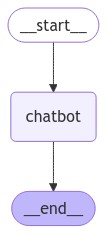

In [30]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

In [8]:
# Initialize Wikipedia API wrapper to fetch top 1 result 
api_wrapper = WikipediaAPIWrapper(top_k_results=1)    
# Create a Wikipedia query tool using the API wrapper 
wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper)  
tools = [wikipedia_tool]

In [34]:
# Bind the Wikipedia tool to the language model
model_with_tools = model.bind_tools(tools)

# Modify chatbot function to respond with Wikipedia
def chatbot(state: State):
    return {"messages": [model_with_tools.invoke(state["messages"])]}

In [35]:
from langgraph.prebuilt import ToolNode, tools_condition

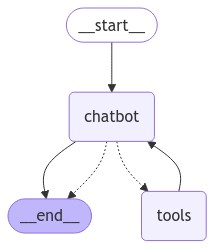

In [36]:
# Initialize StateGraph
graph_builder = StateGraph(State)
# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Create a ToolNode to handle tool calls and add it to the graph
tool_node = ToolNode(tools=[wikipedia_tool])
graph_builder.add_node("tools", tool_node)

# Set up a condition to direct from chatbot to tool or END node
graph_builder.add_conditional_edges("chatbot", tools_condition)

# Connect tools back to chatbot and connect START and END nodes
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
def stream_tool_responses(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # Return the agent's last response
        for value in event.values():
            print("Agent:", value["messages"])
            
# Define the query and run the chatbot
user_query = "US Congress"
stream_tool_responses(user_query)

Agent: [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Jb13ZiW2fN105RmMqHizrHS9', 'function': {'arguments': '{"query":"US Congress"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 83, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-462ecf33-1407-4ed4-88bc-0b27dc887530-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'US Congress'}, 'id': 'call_Jb13ZiW2fN105RmMqHizrHS9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 83, 'output_tokens': 15, 'total_tokens': 98})]
Agent: [ToolMessage(content="Page: United States Congress\nSummary: The United States C

In [16]:
from langgraph.checkpoint.memory import MemorySaver

# Modify the graph with memory checkpointing
memory = MemorySaver()

In [39]:
# Initialize StateGraph
graph_builder = StateGraph(State)
# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Create a ToolNode to handle tool calls and add it to the graph
tool_node = ToolNode(tools=[wikipedia_tool])
graph_builder.add_node("tools", tool_node)

# Set up a condition to direct from chatbot to tool or END node
graph_builder.add_conditional_edges("chatbot", tools_condition)

# Connect tools back to chatbot and connect START and END nodes
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=memory)

In [40]:
# Set up a streaming function for a single user
def stream_memory_responses(user_input: str):
    config = {"configurable": {"thread_id": "single_session_memory"}}
    # Stream the events in the graph
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        # Return the agent's last response
        for value in event.values():
            if "messages" in value and value["messages"]:
                print("Agent:", value["messages"])

In [41]:
stream_memory_responses("Tell me about the Eiffel Tower.")
stream_memory_responses("Who built it?")

Agent: [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wlVGWTqdWNcZtWRI9X8tvxGI', 'function': {'arguments': '{"query":"Eiffel Tower"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 88, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6cd2ceea-513e-48b2-aca3-cc99c9d3e084-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Eiffel Tower'}, 'id': 'call_wlVGWTqdWNcZtWRI9X8tvxGI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 88, 'output_tokens': 16, 'total_tokens': 104})]
Agent: [ToolMessage(content='Page: Eiffel Tower\nSummary: The Eiffel Tower (  EYE-f

## Graph com múltiplas tools

In [ ]:
# Import modules required for defining tool nodes
from langgraph.prebuilt import ToolNode

In [22]:
# Use a decorator to label the tool and set the input format to string
@tool
def historical_events(date_input: str) -> str:
    """Provide a list of important historical events for a given date in any format."""
    try:

      	# Invoke the LLM to interpret the date and generate historical events
        response = model.invoke(f"List important historical events that occurred on {date_input}.")
        
        # Return the response
        return response.content

    # Set an exception block for errors in retrieval
    except Exception as e:
        return f"Error retrieving events: {str(e)}"

In [6]:
@tool
# Set input format to string
def palindrome_checker(text: str) -> str:
    """Check if a word or phrase is a palindrome."""
    
    # Remove non-alphanumeric characters and convert to lowercase
    cleaned_text = ''.join(char.lower() for char in text if char.isalnum())
    
    # Set up if-else block to check reversed text against original text
    if cleaned_text == cleaned_text[::-1]:
        return f"The phrase or word '{text}' is a palindrome."
    else:
        # Print an alternative statement if text is not a palindrome
        return f"The phrase or word '{text}' is not a palindrome."

In [23]:
# List of tools
tools = [wikipedia_tool, palindrome_checker, historical_events]

# Pass the tools to the ToolNode()
tool_node = ToolNode(tools)

# Bind tools to the LLM
model_with_tools = model.bind_tools(tools)

In [10]:
from langgraph.graph import MessagesState, START, END
# Use MessagesState to define the state of the stopping function
def should_continue(state: MessagesState):
    # Get the last message from the state
    last_message = state["messages"][-1]
    # Check if the last message includes tool calls
    if last_message.tool_calls:
        return "tools"
    # End the conversation if no tool calls are present
    return END

In [11]:
def call_model(state: MessagesState):
    last_message = state["messages"][-1]
    # If the last message has tool calls, return the tool's response
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
    # Return the messages from the tool call
        return {"messages": [AIMessage(content=last_message.tool_calls[0]["response"])]}
    # Otherwise, proceed with a regular LLM response
    return {"messages": [model_with_tools.invoke(state["messages"])]}

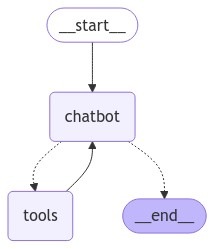

In [24]:
workflow = StateGraph(State)
# Add nodes for chatbot and tools
workflow.add_node("chatbot", call_model)
workflow.add_node("tools", tool_node)

# Connect the START node to the chatbot
workflow.add_edge(START, "chatbot")
# Define conditions, then loop back to chatbot
workflow.add_conditional_edges("chatbot", should_continue, ["tools", END])
workflow.add_edge("tools", "chatbot")

# Set up memory and compile the workflow
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
from langchain_core.messages import AIMessage, HumanMessage
config = {"configurable": {"thread_id": "1"}}
# Create input message with the user's query
def multi_tool_output(query):
    inputs = {"messages": [HumanMessage(content=query)]}
    # Stream messages and metadata from the chatbot application
    for msg, metadata in app.stream(inputs, config, stream_mode="messages"):
    # Check if the message has content and is not from a human
        if msg.content and not isinstance(msg, HumanMessage):
            print(msg.content, end="", flush=True)
    print("\n")

In [25]:
# Call the chatbot with different tools
multi_tool_output("Is `may a moody baby doom a yam` a palindrome?")
multi_tool_output("What happened on 20th July, 1969?")

The phrase or word 'may a moody baby doom a yam' is a palindrome.Yes, the phrase "may a moody baby doom a yam" is a palindrome.

On July 20, 1969, one of the most significant events in human history took place: the Apollo 11 mission successfully landed the first humans on the Moon. Astronauts Neil Armstrong and Buzz Aldrin became the first and second people to walk on the lunar surface, while Michael Collins remained in orbit around the Moon in the command module. Armstrong's famous words as he stepped onto the Moon were, "That's one small step for [a] man, one giant leap for mankind." This event marked a major milestone in the space race and the exploration of outer space.On July 20, 1969, one of the most significant events in human history took place: the Apollo 11 mission successfully landed the first humans on the Moon. Astronauts Neil Armstrong and Buzz Aldrin became the first and second people to walk on the lunar surface, while Michael Collins remained in orbit around the Moon i

In [26]:
# Print the user query first for every interaction 
def user_agent_multiturn(queries):
    for query in queries:
        print(f"User: {query}")
    # Stream through messages corresponding to queries, excluding metadata
        print("Agent: " + "".join(msg.content for msg, metadata in app.stream(
    {"messages": [HumanMessage(content=query)]}, config, stream_mode="messages")
    # Filter out the human messages to print agent messages
        if msg.content and not isinstance(msg, HumanMessage)) + "\n")  

In [27]:
queries = ["Is `stressed desserts?` a palindrome?", "What about the word `kayak`?",
    "What happened on the May 8th, 1945?", "What about 9 November 1989?"]
user_agent_multiturn(queries)

User: Is `stressed desserts?` a palindrome?
Agent: The phrase or word 'stressed desserts?' is a palindrome.Yes, the phrase "stressed desserts?" is a palindrome.

User: What about the word `kayak`?
Agent: The phrase or word 'kayak' is a palindrome.Yes, the word "kayak" is a palindrome.

User: What happened on the May 8th, 1945?
Agent: On May 8, 1945, several significant historical events occurred, the most notable being:

1. **Victory in Europe Day (V-E Day)**: This day marked the official end of World War II in Europe. Germany's unconditional surrender to the Allied forces was ratified, leading to widespread celebrations across Europe and North America. It signified the defeat of Nazi Germany and the conclusion of the war in Europe, although fighting would continue in the Pacific until Japan's surrender later in 1945.

2. **Surrender of German Forces**: The surrender was formally signed in multiple locations, including in Berlin and Reims, France. The surrender document included repres